In [20]:
import os
import pandas as pd
import numpy as np
import librosa
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from keras.models import Sequential
from keras.layers import Dense

In [21]:
def extract_features(folder_path, label):
    features = []
    headers = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)
            audio, sr = librosa.load(file_path, sr=None)
            # Extract features
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)
            spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
            zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)
            # Calculate means
            mfccs_mean = np.mean(mfccs, axis=1)
            chroma_stft_mean = np.mean(chroma_stft, axis=1)
            spectral_centroid_mean = np.mean(spectral_centroid)
            spectral_bandwidth_mean = np.mean(spectral_bandwidth)
            spectral_rolloff_mean = np.mean(spectral_rolloff)
            zero_crossing_rate_mean = np.mean(zero_crossing_rate)
            # Store feature values
            features.append(list(mfccs_mean) + [chroma_stft_mean[0], spectral_centroid_mean,
                                                spectral_bandwidth_mean, spectral_rolloff_mean,
                                                zero_crossing_rate_mean])
            # Store feature headers
            headers=(['mfcc_' + str(i) for i in range(len(mfccs_mean))] +
                           ['chroma_stft', 'spectral_centroid', 'spectral_bandwidth',
                            'spectral_rolloff', 'zero_crossing_rate'])

    df = pd.DataFrame(features, columns=headers)
    df['label'] = label
    return df

data_path = r'augmented_audios'
all_data = pd.DataFrame()
for class_folder in os.listdir(data_path):
    if os.path.isdir(os.path.join(data_path, class_folder)):
        class_path = os.path.join(data_path, class_folder)
        df = extract_features(class_path, class_folder)
        all_data = pd.concat([all_data, df], ignore_index=True)
data_path = r'emotion_dataset'
for class_folder in os.listdir(data_path):
    if os.path.isdir(os.path.join(data_path, class_folder)):
        class_path = os.path.join(data_path, class_folder)
        df = extract_features(class_path, class_folder)
        all_data = pd.concat([all_data, df], ignore_index=True)

# Print headers and up to 20 examples for each feature
for col in all_data.columns:
    print(f"Feature: {col}")
    if col != 'label':
        examples = all_data[col].values
        print(examples)
    print()




Feature: mfcc_0
[-275.84668 -239.42291 -269.5884  -275.00198 -257.43594 -248.43385
 -276.8321  -245.77003 -258.90732 -254.82765 -237.62001 -281.13516
 -309.41888 -244.54222 -244.56409 -243.67816 -263.5582  -252.62428
 -227.12616 -267.64935 -240.2808  -351.3737  -285.1073  -301.385
 -329.8662  -255.31482 -339.81693 -266.9107  -262.76242 -287.49313
 -260.03564 -265.35364 -225.45773 -274.8678  -191.8322  -242.66663
 -238.22531 -224.05473 -189.94716 -217.74747 -242.67462 -240.5489
 -264.36072 -273.40085 -218.94377 -230.83055 -279.35324 -220.4622
 -238.12134 -221.47061 -226.38812 -398.49286 -232.33914 -316.75607
 -263.25275 -245.45178 -294.49777 -256.6439  -225.07281 -253.66713
 -274.9328  -338.80267 -251.2245  -360.16663 -277.44077 -289.9147
 -312.62415 -278.30005 -271.63162 -309.45114 -340.96695 -259.65433
 -285.3395  -284.56818 -289.3538  -259.92572 -338.59277 -286.48825
 -270.90393 -314.92636 -249.66393 -271.14487 -311.52362 -324.21362
 -258.25952 -236.24556 -261.79172 -298.8403  -289.4

In [1]:
import matplotlib.pyplot as plt

def plot_histograms(data):
    classes = data['label'].unique()
    num_features = len(data.columns) - 1  # Exclude the 'label' column
    for i, name in enumerate(data.columns[:-1]):
        feature_name = name
        feature_min = data[feature_name].min()
        feature_max = data[feature_name].max()
        fig, ax = plt.subplots(figsize=(8, 6))
        for label in classes:
            feature_data = data[data['label'] == label][feature_name]
            ax.hist(feature_data, bins=20, alpha=0.5, label=label, range=(feature_min, feature_max))
        ax.legend()
        ax.set_title(f'MFCC {name} Histogram')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        plt.show()
#plot_histograms(all_data)

In [2]:
import seaborn as sns

def plot_dot_plots(data):
    num_features = len(data.columns) - 1  # Exclude the 'label' column
#     features = [f'mfcc_{i+1}' for i in range(num_features)]
    features=data.columns[:-1]
    sns.set(style="ticks")

    for i, feature_x in enumerate(features):
        for j, feature_y in enumerate(features):
            if i != j:
                fig, ax = plt.subplots()
                sns.scatterplot(data=data, x=feature_x, y=feature_y, hue='label', ax=ax)
                ax.set_title(f'{feature_x} vs {feature_y}')
                plt.show()

#plot_dot_plots(all_data)

In [24]:
def plot_feature_heatmap(data):
    num_features = len(data.columns) - 1  # Exclude the 'label' column
#     features = [f'mfcc_{i+1}' for i in range(num_features)]
    features=data.columns[:-1]
    
    # Compute the correlation matrix
    corr = data[features].corr()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title('Feature Correlation Heatmap')
    plt.show()

def plot_class_feature_heatmaps(data):
    classes = data['label'].unique()
    num_features = len(data.columns) - 1  # Exclude the 'label' column
#     features = [f'mfcc_{i+1}' for i in range(num_features)]
#     features=data.columns
    features=data.columns[:-1]
    
    for label in classes:
        label_data = data[data['label'] == label]
        # Compute the correlation matrix
        corr = label_data[features].corr()

        # Plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
        plt.title(f'Feature Correlation Heatmap for {label}')
        plt.show()


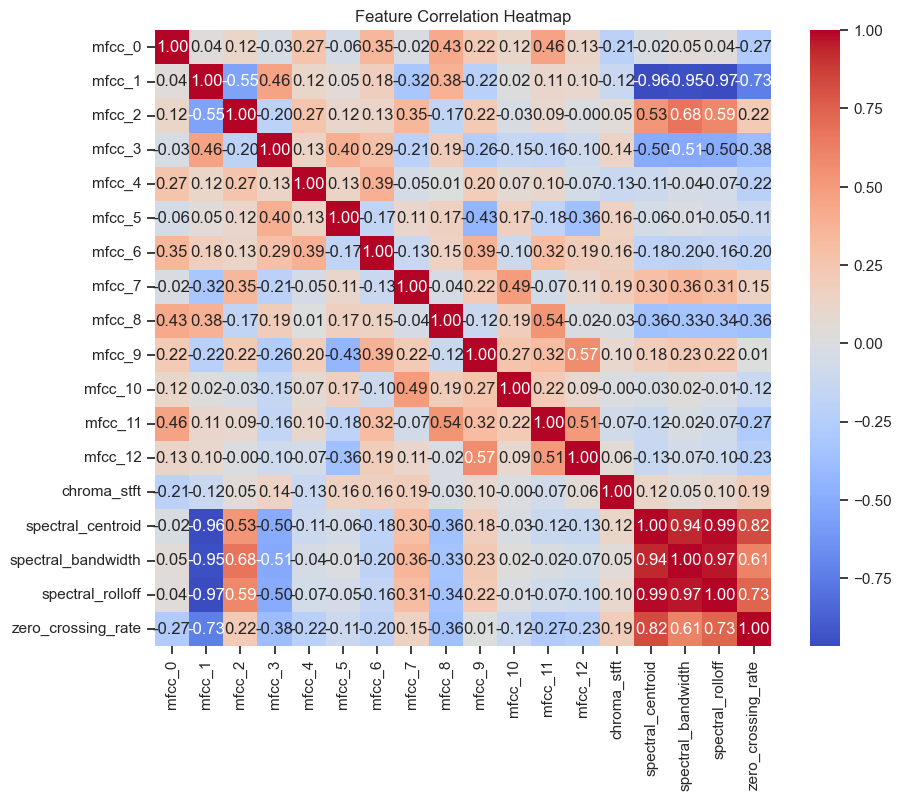

In [25]:
plot_feature_heatmap(all_data)

In [3]:
#plot_class_feature_heatmaps(all_data)

In [41]:
def select_best_features(X_train, y_train):
    # Initialize Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    # Fit classifier to the data
    clf.fit(X_train, y_train)
    # Select features based on feature importance
    sfm = SelectFromModel(clf)
    sfm.fit(X_train, y_train)
    return sfm

def build_model(input_dim, output_dim):
    model = Sequential([
        Dense(64, input_shape=(input_dim,), activation='relu'),
        Dense(32, activation='relu'),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Load your extracted features data
data_path = r"archive_2/"
df = all_data.copy()

# Encode labels
le = LabelEncoder()
print(df['label'][1:400:100])
df['label'] = le.fit_transform(df['label'])
print(df['label'][1:400:100])

# Split data into features and labels
X = df.drop(columns=['label'])
y = df['label']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Select best features for each class
sfm = select_best_features(X_train, y_train)

# Transform features
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)

# Build deep learning model
input_dim = X_train_selected.shape[1]
output_dim = len(np.unique(y_train))
model = build_model(input_dim, output_dim)

# Train model
model.fit(X_train_selected, pd.get_dummies(y_train), epochs=500, batch_size=len(X_train/4), verbose=2)

# Evaluate model
loss, accuracy = model.evaluate(X_test_selected, pd.get_dummies(y_test))
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


1        Angry
101      Happy
201    Neutral
301        Sad
Name: label, dtype: object
1      0
101    1
201    2
301    3
Name: label, dtype: int32
Epoch 1/500
1/1 - 1s - loss: 86.1633 - accuracy: 0.2578 - 685ms/epoch - 685ms/step
Epoch 2/500
1/1 - 0s - loss: 81.5845 - accuracy: 0.2578 - 5ms/epoch - 5ms/step
Epoch 3/500
1/1 - 0s - loss: 77.1362 - accuracy: 0.2578 - 5ms/epoch - 5ms/step
Epoch 4/500
1/1 - 0s - loss: 72.8249 - accuracy: 0.2578 - 4ms/epoch - 4ms/step
Epoch 5/500
1/1 - 0s - loss: 68.6323 - accuracy: 0.2578 - 4ms/epoch - 4ms/step
Epoch 6/500
1/1 - 0s - loss: 64.5538 - accuracy: 0.2578 - 5ms/epoch - 5ms/step
Epoch 7/500
1/1 - 0s - loss: 60.5979 - accuracy: 0.2578 - 5ms/epoch - 5ms/step
Epoch 8/500
1/1 - 0s - loss: 56.7391 - accuracy: 0.2578 - 3ms/epoch - 3ms/step
Epoch 9/500
1/1 - 0s - loss: 52.9750 - accuracy: 0.2578 - 5ms/epoch - 5ms/step
Epoch 10/500
1/1 - 0s - loss: 49.2993 - accuracy: 0.2578 - 4ms/epoch - 4ms/step
Epoch 11/500
1/1 - 0s - loss: 45.7243 - accuracy: 0.2578

Epoch 103/500
1/1 - 0s - loss: 1.0468 - accuracy: 0.5828 - 5ms/epoch - 5ms/step
Epoch 104/500
1/1 - 0s - loss: 1.0409 - accuracy: 0.5844 - 4ms/epoch - 4ms/step
Epoch 105/500
1/1 - 0s - loss: 1.0345 - accuracy: 0.5875 - 4ms/epoch - 4ms/step
Epoch 106/500
1/1 - 0s - loss: 1.0271 - accuracy: 0.5922 - 5ms/epoch - 5ms/step
Epoch 107/500
1/1 - 0s - loss: 1.0194 - accuracy: 0.5953 - 5ms/epoch - 5ms/step
Epoch 108/500
1/1 - 0s - loss: 1.0121 - accuracy: 0.5938 - 4ms/epoch - 4ms/step
Epoch 109/500
1/1 - 0s - loss: 1.0055 - accuracy: 0.5906 - 4ms/epoch - 4ms/step
Epoch 110/500
1/1 - 0s - loss: 0.9993 - accuracy: 0.5922 - 4ms/epoch - 4ms/step
Epoch 111/500
1/1 - 0s - loss: 0.9930 - accuracy: 0.5984 - 4ms/epoch - 4ms/step
Epoch 112/500
1/1 - 0s - loss: 0.9865 - accuracy: 0.5984 - 4ms/epoch - 4ms/step
Epoch 113/500
1/1 - 0s - loss: 0.9799 - accuracy: 0.6016 - 3ms/epoch - 3ms/step
Epoch 114/500
1/1 - 0s - loss: 0.9738 - accuracy: 0.6000 - 5ms/epoch - 5ms/step
Epoch 115/500
1/1 - 0s - loss: 0.9682 - 

Epoch 206/500
1/1 - 0s - loss: 0.6856 - accuracy: 0.7516 - 4ms/epoch - 4ms/step
Epoch 207/500
1/1 - 0s - loss: 0.6842 - accuracy: 0.7547 - 4ms/epoch - 4ms/step
Epoch 208/500
1/1 - 0s - loss: 0.6829 - accuracy: 0.7563 - 6ms/epoch - 6ms/step
Epoch 209/500
1/1 - 0s - loss: 0.6815 - accuracy: 0.7563 - 5ms/epoch - 5ms/step
Epoch 210/500
1/1 - 0s - loss: 0.6802 - accuracy: 0.7563 - 4ms/epoch - 4ms/step
Epoch 211/500
1/1 - 0s - loss: 0.6789 - accuracy: 0.7563 - 5ms/epoch - 5ms/step
Epoch 212/500
1/1 - 0s - loss: 0.6776 - accuracy: 0.7594 - 6ms/epoch - 6ms/step
Epoch 213/500
1/1 - 0s - loss: 0.6764 - accuracy: 0.7594 - 5ms/epoch - 5ms/step
Epoch 214/500
1/1 - 0s - loss: 0.6751 - accuracy: 0.7594 - 4ms/epoch - 4ms/step
Epoch 215/500
1/1 - 0s - loss: 0.6739 - accuracy: 0.7609 - 6ms/epoch - 6ms/step
Epoch 216/500
1/1 - 0s - loss: 0.6727 - accuracy: 0.7609 - 5ms/epoch - 5ms/step
Epoch 217/500
1/1 - 0s - loss: 0.6715 - accuracy: 0.7625 - 6ms/epoch - 6ms/step
Epoch 218/500
1/1 - 0s - loss: 0.6703 - 

Epoch 309/500
1/1 - 0s - loss: 0.5946 - accuracy: 0.7844 - 5ms/epoch - 5ms/step
Epoch 310/500
1/1 - 0s - loss: 0.5940 - accuracy: 0.7844 - 4ms/epoch - 4ms/step
Epoch 311/500
1/1 - 0s - loss: 0.5934 - accuracy: 0.7844 - 4ms/epoch - 4ms/step
Epoch 312/500
1/1 - 0s - loss: 0.5928 - accuracy: 0.7875 - 4ms/epoch - 4ms/step
Epoch 313/500
1/1 - 0s - loss: 0.5923 - accuracy: 0.7875 - 4ms/epoch - 4ms/step
Epoch 314/500
1/1 - 0s - loss: 0.5917 - accuracy: 0.7875 - 4ms/epoch - 4ms/step
Epoch 315/500
1/1 - 0s - loss: 0.5911 - accuracy: 0.7891 - 6ms/epoch - 6ms/step
Epoch 316/500
1/1 - 0s - loss: 0.5905 - accuracy: 0.7906 - 5ms/epoch - 5ms/step
Epoch 317/500
1/1 - 0s - loss: 0.5900 - accuracy: 0.7906 - 7ms/epoch - 7ms/step
Epoch 318/500
1/1 - 0s - loss: 0.5894 - accuracy: 0.7922 - 6ms/epoch - 6ms/step
Epoch 319/500
1/1 - 0s - loss: 0.5889 - accuracy: 0.7922 - 5ms/epoch - 5ms/step
Epoch 320/500
1/1 - 0s - loss: 0.5883 - accuracy: 0.7922 - 6ms/epoch - 6ms/step
Epoch 321/500
1/1 - 0s - loss: 0.5878 - 

Epoch 412/500
1/1 - 0s - loss: 0.5495 - accuracy: 0.8125 - 6ms/epoch - 6ms/step
Epoch 413/500
1/1 - 0s - loss: 0.5492 - accuracy: 0.8141 - 4ms/epoch - 4ms/step
Epoch 414/500
1/1 - 0s - loss: 0.5489 - accuracy: 0.8141 - 5ms/epoch - 5ms/step
Epoch 415/500
1/1 - 0s - loss: 0.5485 - accuracy: 0.8141 - 5ms/epoch - 5ms/step
Epoch 416/500
1/1 - 0s - loss: 0.5482 - accuracy: 0.8141 - 6ms/epoch - 6ms/step
Epoch 417/500
1/1 - 0s - loss: 0.5478 - accuracy: 0.8141 - 4ms/epoch - 4ms/step
Epoch 418/500
1/1 - 0s - loss: 0.5475 - accuracy: 0.8141 - 4ms/epoch - 4ms/step
Epoch 419/500
1/1 - 0s - loss: 0.5472 - accuracy: 0.8141 - 5ms/epoch - 5ms/step
Epoch 420/500
1/1 - 0s - loss: 0.5468 - accuracy: 0.8141 - 5ms/epoch - 5ms/step
Epoch 421/500
1/1 - 0s - loss: 0.5465 - accuracy: 0.8141 - 5ms/epoch - 5ms/step
Epoch 422/500
1/1 - 0s - loss: 0.5462 - accuracy: 0.8141 - 4ms/epoch - 4ms/step
Epoch 423/500
1/1 - 0s - loss: 0.5459 - accuracy: 0.8141 - 6ms/epoch - 6ms/step
Epoch 424/500
1/1 - 0s - loss: 0.5455 - 

In [42]:
import pyaudio
import wave
import librosa
import numpy as np

def record_audio(output_file, duration, fs):
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=fs,
                    input=True,
                    frames_per_buffer=CHUNK)
    frames = []
    print("Recording...")
    for i in range(0, int(fs / CHUNK * duration)):
        data = stream.read(CHUNK)
        frames.append(data)
    print("Finished recording.")
    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(output_file, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(fs)
    wf.writeframes(b''.join(frames))
    wf.close()

def predict_emotion_from_audio(audio_file_path, model, feature_selector, label_encoder):
    # Load the audio file
    audio, sr = librosa.load(audio_file_path, sr=None)
    # Extract features from the audio
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)
    # Calculate means
    mfccs_mean = np.mean(mfccs, axis=1)
    chroma_stft_mean = np.mean(chroma_stft)
    spectral_centroid_mean = np.mean(spectral_centroid)
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)
    spectral_rolloff_mean = np.mean(spectral_rolloff)
    zero_crossing_rate_mean = np.mean(zero_crossing_rate)
    # Concatenate features into a single array
    features = np.concatenate([mfccs_mean, [chroma_stft_mean, spectral_centroid_mean,
                                            spectral_bandwidth_mean, spectral_rolloff_mean,
                                            zero_crossing_rate_mean]])
    # Select best features using the feature selector
    selected_features = feature_selector.transform(features.reshape(1, -1))
    # Predict emotion using the model
    predicted_label = model.predict(selected_features)
    print(predicted_label)
    # Map predicted label to emotion
    max_prob=np.array(predicted_label).argmax()
    
    predicted_emotion = label_encoder.inverse_transform([max_prob])[0]
    return predicted_emotion

def predict_emotion_from_microphone(model, feature_selector, label_encoder, duration=5, fs=44100, output_file='temp.wav'):
    # Record audio from microphone
    record_audio(output_file, duration, fs)
    # Predict emotion from recorded audio
    predicted_emotion = predict_emotion_from_audio(output_file, model, feature_selector, label_encoder)
    return predicted_emotion

# Example usage:
predicted_emotion = predict_emotion_from_microphone(model, sfm, le, 10)
print("Predicted Emotion:", predicted_emotion)


Recording...
Finished recording.
1/1 [==============================] - 0s 54ms/step
[[0.00050956 0.4598462  0.23497084 0.30467343]]
Predicted Emotion: Happy


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(
